In [1]:
import numpy as np 
np.random.seed(1337) #reproducibility
import pandas as pd
import os
import pandas as pd
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import gc
import IPython.display as ipd 
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
from pyspark.sql import SparkSession
from pyspark.sql import Row

spark = SparkSession.builder \
    .appName("speech recognition") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.memoryOverhead", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.default.parallelism", 200) \
    .getOrCreate()

train_path = './train/train/'
test_path = './test/test/'

In [2]:
filename = 'de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac'

In [3]:
data, samplerate = sf.read(train_path+filename)

In [4]:
import gc
gc.collect()

0

In [5]:
data.shape

(220500,)

In [6]:
data[:10]

array([-0.03903198, -0.03997803, -0.05319214, -0.06002808, -0.0531311 ,
       -0.04608154, -0.04348755, -0.02947998, -0.02307129, -0.02459717])

In [7]:
samplerate

22050

Text(0.5, 0, 'Time [sec]')

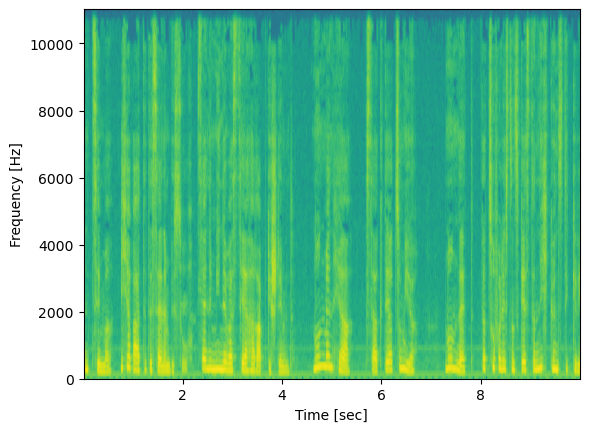

In [8]:
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time in samples')

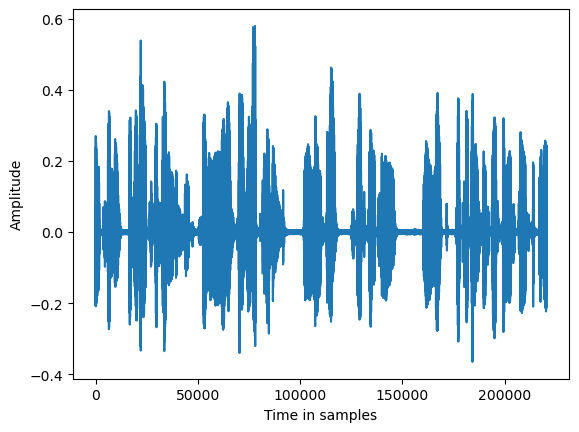

In [9]:
plt.plot(data)

# add axis labels
plt.ylabel('Amplitude')
plt.xlabel('Time in samples')

In [10]:
#para train path
label = []
for filename in os.listdir(train_path):
    label.append(filename[:2]) #es [:2] porque el idioma esta en los dos primeros elementos

#para test path
label_t = []
for filename in os.listdir(test_path):
    label_t.append(filename[:2])

print(len(label))
print(len(label_t))

73080
540


In [11]:
file = []
for filename in os.listdir(train_path):
    file.append(filename)

file_t = []
for filename in os.listdir(test_path):
    file_t.append(filename)

Label = pd.DataFrame(label,columns=['Language'])

Label['Language'].value_counts()

Language
de    24360
en    24360
es    24360
Name: count, dtype: int64

In [12]:
data = {'filename':file,
       'languange':label}

data_t = {'filename':file_t,
       'languange':label_t}

#df es el dataframe de train
df = pd.DataFrame(data)

df

,filename,languange
0,de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...,de
1,de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...,de
2,de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...,de
3,de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...,de
4,de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment...,de
...,...,...
73075,es_m_f7d959494477e5e7e33d4666f15311c9.fragment...,es
73076,es_m_f7d959494477e5e7e33d4666f15311c9.fragment...,es
73077,es_m_f7d959494477e5e7e33d4666f15311c9.fragment...,es
73078,es_m_f7d959494477e5e7e33d4666f15311c9.fragment...,es


In [14]:
spark_df = spark.createDataFrame(df)

#spark_df.printSchema()
spark_df.printSchema()

root
 |-- filename: string (nullable = true)
 |-- languange: string (nullable = true)



In [13]:
#df_t es el dataframe de test
df_t = pd.DataFrame(data_t)

df['filename'][0]


'de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac'

In [15]:
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType
import numpy as np

def generate_fb_and_mfcc_udf(signal, sample_rate):
    def calculate_fb_and_mfcc(signal_value, sample_rate_value):
        # Pre-Emphasis
        pre_emphasis = 0.97
        emphasized_signal = np.append(
            signal_value[0],
            signal_value[1:] - pre_emphasis * signal_value[:-1])

        # Framing
        frame_size = 0.025
        frame_stride = 0.01

        # Convert from seconds to samples
        frame_length, frame_step = (
            frame_size * sample_rate_value,
            frame_stride * sample_rate_value)
        signal_length = len(emphasized_signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))

        # Make sure that we have at least 1 frame
        num_frames = int(
            np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))

        # Pad Signal to make sure that all frames have equal
        # number of samples without truncating any samples
        # from the original signal
        pad_signal = np.append(emphasized_signal, z)

        indices = (
            np.tile(np.arange(0, frame_length), (num_frames, 1)) +
            np.tile(
                np.arange(0, num_frames * frame_step, frame_step),
                (frame_length, 1)
            ).T
        )
        frames = pad_signal[indices.astype(np.int32, copy=False)]

        # Window
        frames *= np.hamming(frame_length)

        # Fourier-Transform and Power Spectrum
        NFFT = 512

        # Magnitude of the FFT
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

        # Power Spectrum
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

        # Filter Banks
        nfilt = 40

        low_freq_mel = 0

        # Convert Hz to Mel
        high_freq_mel = (2595 * np.log10(1 + (sample_rate_value / 2) / 700))

        # Equally spaced in Mel scale
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

        # Convert Mel to Hz
        hz_points = (700 * (10**(mel_points / 2595) - 1))
        bin = np.floor((NFFT + 1) * hz_points / sample_rate_value)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(pow_frames, fbank.T)

        # Numerical Stability
        filter_banks = np.where(
            filter_banks == 0,
            np.finfo(float).eps,
            filter_banks)

        # dB
        filter_banks = 20 * np.log10(filter_banks)
        filter_banks_list = filter_banks.tolist()
        return filter_banks

    return F.udf(calculate_fb_and_mfcc, returnType=ArrayType(FloatType()))

# generate_fb_and_mfcc_udf = F.udf(generate_fb_and_mfcc_udf, returnType=ArrayType(FloatType()))

In [16]:
spark_df = spark.createDataFrame(df)
train_df, test_df = spark_df.randomSplit([0.5, 0.5], seed=0)
train_df.groupBy("languange").count().show()
test_df.groupBy("languange").count().show()


+---------+-----+
|languange|count|
+---------+-----+
|       de|12232|
|       en|12121|
|       es|12230|
+---------+-----+

+---------+-----+
|languange|count|
+---------+-----+
|       de|12128|
|       en|12239|
|       es|12130|
+---------+-----+



In [17]:
# train_df, test_df = train_df.randomSplit([0.5, 0.5], seed=0)
# train_df.groupBy("languange").count().show()
# test_df.groupBy("languange").count().show()

In [18]:
# train_df, test_df = train_df.randomSplit([0.5, 0.5], seed=0)
# train_df.groupBy("languange").count().show()
# test_df.groupBy("languange").count().show()

In [19]:
# train_df, test_df = train_df.randomSplit([0.5, 0.5], seed=0)
# train_df.groupBy("languange").count().show()
# test_df.groupBy("languange").count().show()

In [20]:
# Select the 'filename' column and limit the result to the first two rows
first_two_filenames = train_df.select('filename').limit(2)

# Show the result
first_two_filenames.show()

+--------------------+
|            filename|
+--------------------+
|de_f_0809fd064223...|
|de_f_0809fd064223...|
+--------------------+



In [21]:
train_df.show(5)

+--------------------+---------+
|            filename|languange|
+--------------------+---------+
|de_f_0809fd064223...|       de|
|de_f_0809fd064223...|       de|
|de_f_0809fd064223...|       de|
|de_f_0809fd064223...|       de|
|de_f_0809fd064223...|       de|
+--------------------+---------+
only showing top 5 rows



In [22]:
gc.collect()

165

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import lit
import soundfile as sf
import numpy as np

# Define a UDF to read audio files
def read_audio(filename):
    try:
        flac, samplerate = sf.read(train_path + filename)
        return flac.tolist(), float(samplerate) # Ensure samplerate is float type
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None, None

# Define a UDF to apply the function
read_audio_udf = F.udf(read_audio, returnType=ArrayType(ArrayType(FloatType())))

# Apply the UDF using map
X_train_with_audio = train_df.withColumn("audio_properties", read_audio_udf("filename"))

# Extract the series and length from the array column
X_train_with_audio = X_train_with_audio \
    .withColumn("series", F.col("audio_properties").getItem(0)) \
    .withColumn("length", F.col("audio_properties").getItem(1)) \
    .drop("audio_properties")
X_train_with_audio = X_train_with_audio.withColumn("length", lit(22050))


In [40]:
X_train_with_audio.show(20)

+--------------------+---------+--------------------+------+
|            filename|languange|              series|length|
+--------------------+---------+--------------------+------+
|de_f_0809fd064223...|       de|[-0.01953125, -0....| 22050|
|de_f_0809fd064223...|       de|[-0.0015258789, -...| 22050|
|de_f_0809fd064223...|       de|[-0.030181885, -0...| 22050|
|de_f_0809fd064223...|       de|[0.0017089844, 0....| 22050|
|de_f_0809fd064223...|       de|[-0.01461792, -0....| 22050|
|de_f_0809fd064223...|       de|[-0.029754639, -0...| 22050|
|de_f_0809fd064223...|       de|[-0.03656006, -0....| 22050|
|de_f_0809fd064223...|       de|[-0.02999878, -0....| 22050|
|de_f_0809fd064223...|       de|[-0.02999878, -0....| 22050|
|de_f_0809fd064223...|       de|[-0.030059814, -0...| 22050|
|de_f_0809fd064223...|       de|[-0.031402588, -0...| 22050|
|de_f_0809fd064223...|       de|[-0.031097412, -0...| 22050|
|de_f_0809fd064223...|       de|[-0.029632568, -0...| 22050|
|de_f_0809fd064223...|  

In [25]:
X_train_with_audio.select("filename").show(20, truncate=False)

+-------------------------------------------------------------+
|filename                                                     |
+-------------------------------------------------------------+
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise10.flac |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise11.flac |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise2.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise3.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise6.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise7.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.noise9.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.pitch2.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.pitch3.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.pitch4.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.pitch5.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.pitch7.flac  |
|de_f_0809fd0642232f8c85b0b3d545dc2b5a.f

In [26]:
l = train_df.count()
print(l)

36583


In [27]:
gc.collect()

145

In [29]:
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# # Register UDF with PySpark SQLContext or SparkSession
# spark.udf.register("generate_fb_and_mfcc_udf", generate_fb_and_mfcc_udf, ArrayType(FloatType()))

# # Apply UDF to DataFrame and create a new column
# X_train_with_audio = X_train_with_audio.withColumn(
#     "MFCC_array", 
#     F.expr("generate_fb_and_mfcc_udf(series, length)")
# )

# # Show DataFrame
# #X_train_with_audio.show()

# # Convert DataFrame to Pandas DataFrame and save
# # MFCC_array_pd = X_train_with_audio.select("MFCC_array").toPandas()
# # np.save('./MFCC_data', MFCC_array_pd)




In [31]:
# from pyspark.sql import SparkSession
# from pyspark.sql import functions as F
# from pyspark.sql.types import ArrayType, FloatType
# from pyspark.ml.feature import StandardScaler
# import numpy as np

# # Assuming X_train_with_audio is the DataFrame containing audio series and lengths
# # Define a function to generate MFCCs
# def generate_mfcc(row):
#     series = row['Series']
#     length = row['Length']
#     MFCC = generate_fb_and_mfcc(series, length)  # Assuming generate_fb_and_mfcc is defined elsewhere
#     return sc.fit_transform(MFCC)

# # Define a UDF to apply the function
# generate_mfcc_udf = F.udf(generate_mfcc, returnType=ArrayType(ArrayType(FloatType())))

# # Apply the UDF using map
# MFCC_array = X_train_with_audio.select(generate_mfcc_udf(F.struct("Series", "Length")).alias("MFCC_array"))

# # Convert to Pandas DataFrame for further processing
# #MFCC_pdf = MFCC_array.toPandas()

# # Convert MFCC data to numpy array
# #MFCC_data = np.array(MFCC_pdf['MFCC_array'].tolist())

# # Save MFCC data
# #np.save('./MFCC_data', MFCC_data)

In [32]:
#same for mfcc test insert here
from pyspark.sql.functions import udf
from pyspark.ml.feature import StandardScaler

# Define a UDF to generate MFCC and apply feature scaling
def generate_and_scale_mfcc(series, length):
    try:
        # Generate MFCC features
        MFCC = generate_fb_and_mfcc(series, length)
        
        # Initialize StandardScaler
        scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
        
        # Fit and transform
        scaler_model = scaler.fit(MFCC)
        MFCC_scaled = scaler_model.transform(MFCC)
        
        # Extract scaled features and convert to NumPy array
        scaled_features = MFCC_scaled.select("scaled_features").rdd.map(lambda x: np.array(x)).collect()
        
        return scaled_features
    except Exception as e:
        print(f"Error processing series: {e}")
        return None

# Define UDF
generate_and_scale_mfcc_udf = udf(generate_and_scale_mfcc, ArrayType(ArrayType(FloatType())))

# Apply UDF to DataFrame and create a new column
X_train_with_mfcc = X_train_with_audio.withColumn(
    "MFCC_array", 
    generate_and_scale_mfcc_udf("series", "length")
)


# # Convert MFCC data to numpy array
# #MFCC_data = np.array(MFCC_pdf['MFCC_array'].tolist())

# Show DataFrame
#X_train_with_mfcc.show()


In [33]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import monotonically_increasing_id
from sklearn.model_selection import train_test_split

# Create a StringIndexer to convert language categories into indices
indexer = StringIndexer(inputCol="languange", outputCol="language_index")

# Create a OneHotEncoder to convert language indices into one-hot encoded vectors
encoder = OneHotEncoder(inputCol="language_index", outputCol="language_dummies")

# Define a pipeline to sequentially apply StringIndexer and OneHotEncoder
pipeline = Pipeline(stages=[indexer, encoder])

# Fit the pipeline to training data to obtain the encoder model
pipeline_model = pipeline.fit(train_df)

# Apply the pipeline model to transform both training and testing data
encoded_train = pipeline_model.transform(train_df)
encoded_test = pipeline_model.transform(test_df)

# Save Encoded Language Data
# encoded_train.select("language_dummies").write.csv("language_dummy.csv")
# encoded_test.select("language_dummies").write.csv("language_dummy_t.csv")

# # Load MFCC Data
# MFCC_data = spark.read.load("./MFCC_data.npy")
# language_data = spark.read.load("./language_dummy.npy")
# language_data_t = spark.read.load("./language_dummy_t.npy")

MFCC_array = np.load('./MFCC_data.npy')
language_dummies = np.load('./language_dummy.npy')
language_dummies_t = np.load('./language_dummy_t.npy')

# Split the Data
# train_MFCC, test_MFCC = MFCC_data.randomSplit([0.9, 0.1], seed=0)
# train_lang, test_lang = language_data.randomSplit([0.9, 0.1], seed=0)
# train_lang_t, test_lang_t = language_data_t.randomSplit([0.9, 0.1], seed=0)

X_train_MFCC,X_test_MFCC,y_train_MFCC,y_test_MFCC = train_test_split(MFCC_array,language_dummies,stratify = language_dummies,test_size = 0.10,random_state = 0)

# # Optionally, you may add an ID column to preserve the order of rows
# train_MFCC = train_MFCC.withColumn("id", monotonically_increasing_id())
# test_MFCC = test_MFCC.withColumn("id", monotonically_increasing_id())

X_train_MFCC = X_train_MFCC.reshape(-1,1000,40,1)

X_test_MFCC = X_test_MFCC.reshape(-1,1000,40,1)


In [34]:
!pip install keras

In [35]:
!pip install tensorflow

In [36]:
#cnn

from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.layers import Dropout, Input, Activation
from keras.optimizers import Nadam, SGD, Adam
# from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.layers import BatchNormalization
from keras import regularizers

input_shape = (1000,40,1)
model = Sequential()
model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64,(5,5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


#sgd = SGD(lr=0.01, decay=1, momentum=0.0, nesterov=False)
#sgd = sgd(lr=0.01, decay=1e-6, momentum=0.0, nesterov=False)
#adam = Adam(lr=0.01, decay=1e-6)
import math
from keras.callbacks import LearningRateScheduler
adam = Adam()
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.00158
	drop = 0.9
	epochs_drop = 1
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



checkpoint = ModelCheckpoint(
                'model.keras',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)
#es = EarlyStopping(monitor='val_loss',mode = 'max')
model.fit(
                X_train_MFCC,
                y_train_MFCC,
                epochs=1,
                callbacks=[checkpoint, lrate],
                verbose=1,
                validation_data=(X_test_MFCC, y_test_MFCC),
                batch_size=32)

model.evaluate(X_test_MFCC,y_test_MFCC)

C:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


103/103 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.4032 - loss: 1.7756 - val_accuracy: 0.3880 - val_loss: 2.4573 - learning_rate: 0.0014


C:\anaconda\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3803 - loss: 2.4096


[2.4572951793670654, 0.38797813653945923]

In [37]:
#predictions
y_pred = model.predict(X_test_MFCC)

y_test1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_test_MFCC[i,:])
    y_test1.append(argmax)

y_pred1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_pred[i,:])
    y_pred1.append(argmax)

confusion_matrix(y_test1,y_pred1)

print(classification_report(y_test1,y_pred1))


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step
              precision    recall  f1-score   support

           0       0.36      0.84      0.50       122
           1       0.00      0.00      0.00       122
           2       0.49      0.33      0.39       122

    accuracy                           0.39       366
   macro avg       0.28      0.39      0.30       366
weighted avg       0.28      0.39      0.30       366



C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
#evaluation

MFCC_array_t = np.load('./MFCC_data_t.npy')

MFCC_array_t.shape

MFCC_array_t = MFCC_array_t.reshape(-1,1000,40,1)

predictions = model.predict(MFCC_array_t)

predictions

y_pred1 = []
for i in range(0,len(predictions)):
    argmax = np.argmax(predictions[i,:])
    y_pred1.append(argmax)

y_test1 = []
for i in range(0,len(language_dummies_t)):
    argmax = np.argmax(language_dummies_t[i,:])
    y_test1.append(argmax)

#confusion_matrix(y_test1,y_pred1)
cm = confusion_matrix(y_test1,y_pred1)
print(np.around(cm/cm.sum(axis=1, keepdims=True)*100,1))

print(classification_report(y_test1,y_pred1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step
[[93.9  0.   6.1]
 [45.   0.  55. ]
 [44.4  0.  55.6]]
              precision    recall  f1-score   support

           0       0.51      0.94      0.66       180
           1       0.00      0.00      0.00       180
           2       0.48      0.56      0.51       180

    accuracy                           0.50       540
   macro avg       0.33      0.50      0.39       540
weighted avg       0.33      0.50      0.39       540



C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
